In [1]:

import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import wordcloud
import calendar
import datetime as dt
import re

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel(r"C:\Users\91700\Desktop\ML Project\MBA-Market basket Analysis\Online Retail.xlsx")

# Perform operations on the DataFrame
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
def data_cleaning_and_prep(df):
  
    df["CustomerID"] = df["CustomerID"].fillna(0)
    df["CustomerID"] = df["CustomerID"].astype(int)
    df["CustomerID"] = df["CustomerID"].astype(str)
    df["CustomerID"] = df["CustomerID"].replace('0','Guest Customer')


    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['Year'] = df['InvoiceDate'].dt.year

    df['Month'] = df['Month'].apply(lambda x: calendar.month_name[int(x)])
    df['Week of the Year'] = df['InvoiceDate'].dt.isocalendar().week

    df['Day of Week'] = df['InvoiceDate'].dt.day_name()
    df['Time'] = df['InvoiceDate'].dt.time
    df["Hour"] = df['InvoiceDate'].dt.hour
    df['Time of Day']=pd.cut(df['InvoiceDate'].dt.hour,[0,6,12,18,23],labels=['Night','Morning','Afternoon','Evening'],include_lowest=True)

    index_names = df[df['Year'] == 2010].index
    df.drop(index_names, inplace = True)
    df.drop('Year', axis=1, inplace=True)

    df['InvoiceNo'] = df['InvoiceNo'].dropna()

    df['Sales Revenue'] = df['UnitPrice'] * df['Quantity']

    df.drop(df[df["Country"] == "Unspecified"].index, inplace = True)

    index_names = df[df['Quantity'] <= 0].index
    df.drop(index_names, inplace = True)
    index_names = df[df['Sales Revenue'] <= 0].index
    df.drop(index_names, inplace = True)
    df.drop_duplicates(inplace = True)

    df.dropna(subset = ['Description'], inplace= True)

    df.drop(df[df.Description.str.len() <= 8].index, inplace=True)

    df.drop(df.index[417090], inplace=True)

    df.Description = df.Description.str.lower()

    index_names = df[ df['Description'] == "dotcom postage" ].index

    df.Description = df.Description.str.upper()
    df["Description"] = df["Description"].str.strip()
    df.drop(index_names, inplace = True)

    the_dict = dict()
    df.reset_index(drop=True, inplace=True)
    for i, code in enumerate(df["StockCode"]):
        if code not in the_dict:
            the_dict[code] = list()
        if df["Description"][i] not in the_dict[code]:
            the_dict[code].append(df["Description"][i])

    dict_to_look_at = dict()
    for key in the_dict:
        if len(the_dict[key]) > 1:
            dict_to_look_at[key] = the_dict[key]

    key_list = list(dict_to_look_at.keys())
    for key_l in key_list:
        x = dict_to_look_at[key_l]
        max_len = 0
        index = 0
        for i in range(len(x)):
            if len((x[i]).split()) >= max_len:
                max_len = len((x[i]).split())
                index = i
        dict_to_look_at[key_l] = x[index]

    for key in dict_to_look_at:
        df.loc[df["StockCode"] == key, "Description"] = dict_to_look_at[key]

    return df

df = data_cleaning_and_prep(df)

In [8]:
df.shape

(481313, 16)

In [9]:
df.head()

InvoiceNo StockCode                Description  Quantity  \
0    539993     22386    JUMBO BAG PINK POLKADOT        10   
1    539993     21499         BLUE POLKADOT WRAP        25   
2    539993     21498         RED RETROSPOT WRAP        25   
3    539993     22379    RECYCLING BAG RETROSPOT         5   
4    539993     20718  RED RETROSPOT SHOPPER BAG        10   

          InvoiceDate  UnitPrice CustomerID         Country        Date  \
0 2011-01-04 10:00:00       1.95      13313  United Kingdom  2011-01-04   
1 2011-01-04 10:00:00       0.42      13313  United Kingdom  2011-01-04   
2 2011-01-04 10:00:00       0.42      13313  United Kingdom  2011-01-04   
3 2011-01-04 10:00:00       2.10      13313  United Kingdom  2011-01-04   
4 2011-01-04 10:00:00       1.25      13313  United Kingdom  2011-01-04   

     Month  Week of the Year Day of Week      Time  Hour Time of Day  \
0  January                 1     Tuesday  10:00:00    10     Morning   
1  January                 1     Tuesday  10:00:00    10     Morning   
2  January                 1     Tuesday  10:00:00    10     Morning   
3  January                 1     Tuesday  10:00:00    10     Morning   
4  January                 1     Tuesday  10:00:00    10     Morning   

   Sales Revenue  
0           19.5  
1           10.5  
2           10.5  
3           10.5  
4           12.5

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481313 entries, 0 to 481312
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         481313 non-null  object        
 1   StockCode         481313 non-null  object        
 2   Description       481313 non-null  object        
 3   Quantity          481313 non-null  int64         
 4   InvoiceDate       481313 non-null  datetime64[ns]
 5   UnitPrice         481313 non-null  float64       
 6   CustomerID        481313 non-null  object        
 7   Country           481313 non-null  object        
 8   Date              481313 non-null  object        
 9   Month             481313 non-null  object        
 10  Week of the Year  481313 non-null  UInt32        
 11  Day of Week       481313 non-null  object        
 12  Time              481313 non-null  object        
 13  Hour              481313 non-null  int64         
 14  Time

# EDA

In [12]:
def group_Quantity_and_SalesRevenue(df,string):


    df = df[[f'{string}','Quantity','Sales Revenue']].groupby([f'{string}']).sum().sort_values(by= 'Sales Revenue', ascending = False).reset_index()

    return df

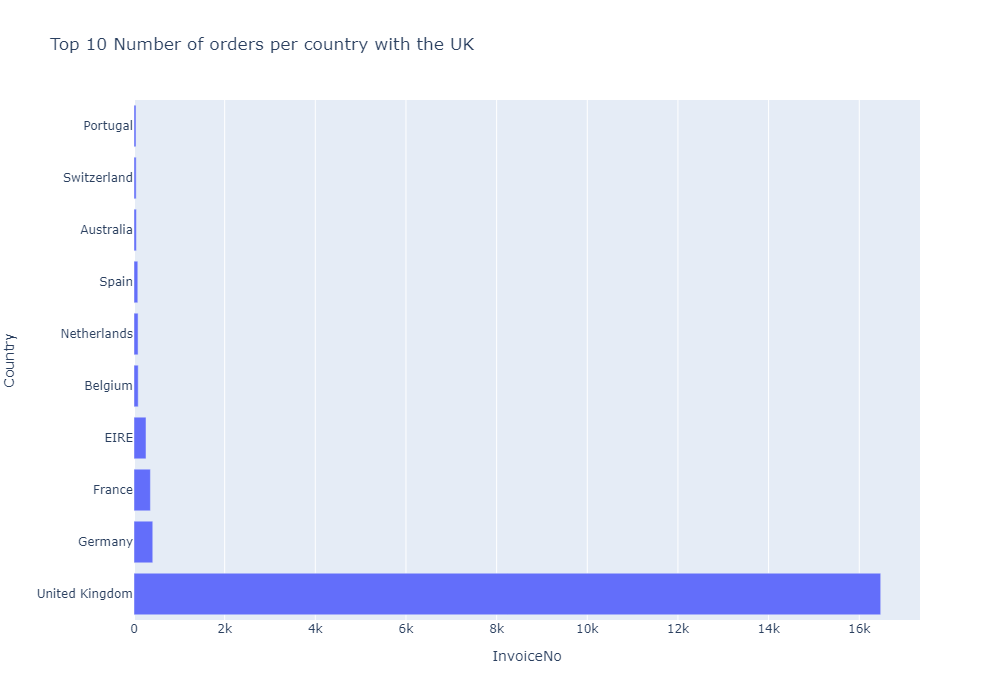

In [14]:
Country_Data = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country with the UK")
fig.show(renderer='png', height=700, width=1000)

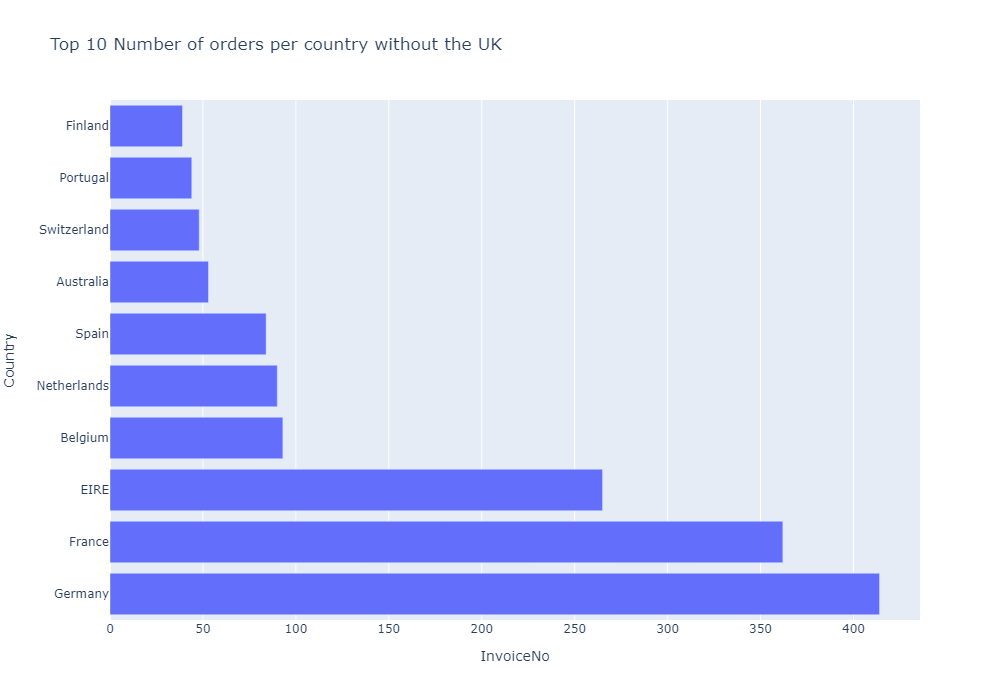

In [16]:
Country_Data = df[df['Country'] != "United Kingdom"].groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country without the UK")
fig.show(renderer='png', height=700, width=1000)


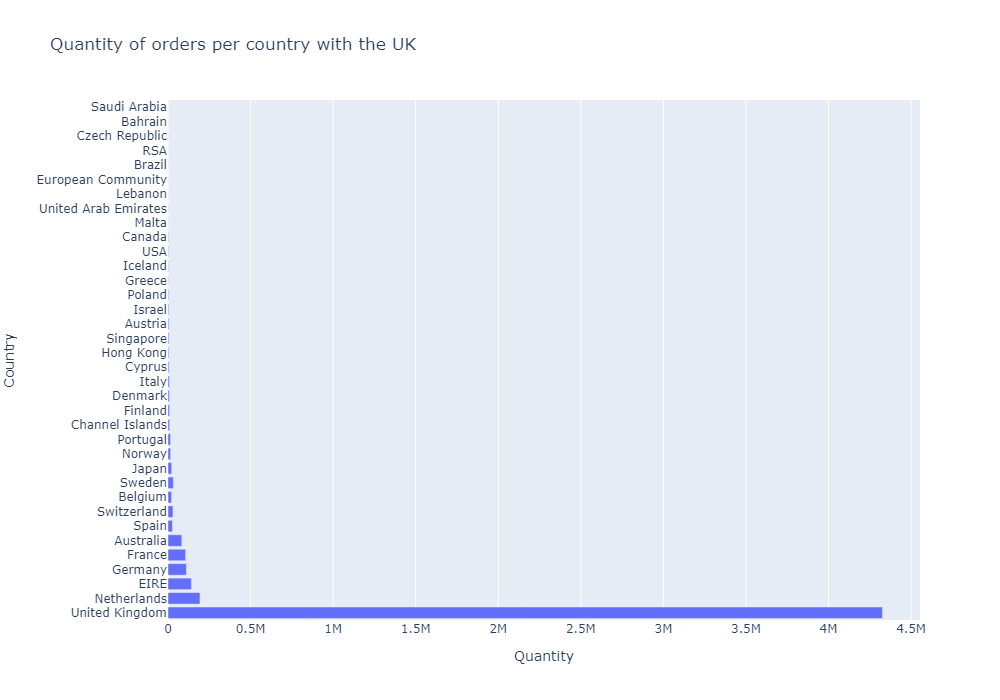

In [17]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Quantity", y='Country', title= "Quantity of orders per country with the UK")
fig.show(renderer='png', height=700, width=1000)

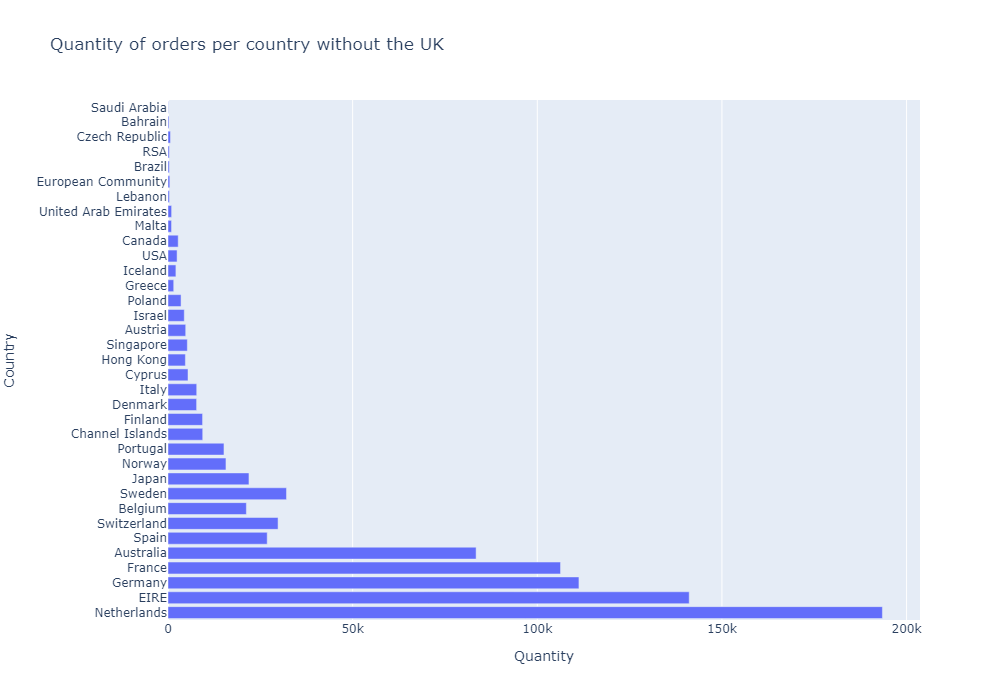

In [18]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Quantity", y='Country', title= "Quantity of orders per country without the UK")
fig.show(renderer='png', height=700, width=1000)

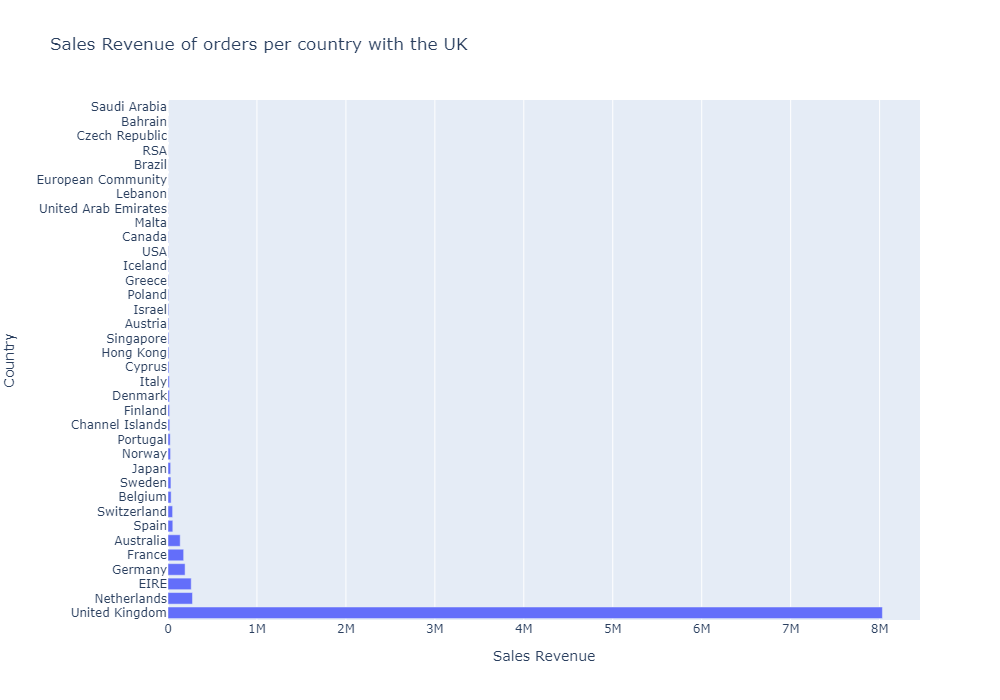

In [19]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')
fig = px.bar(temp_df, x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country with the UK")
fig.show(renderer='png', height=700, width=1000)

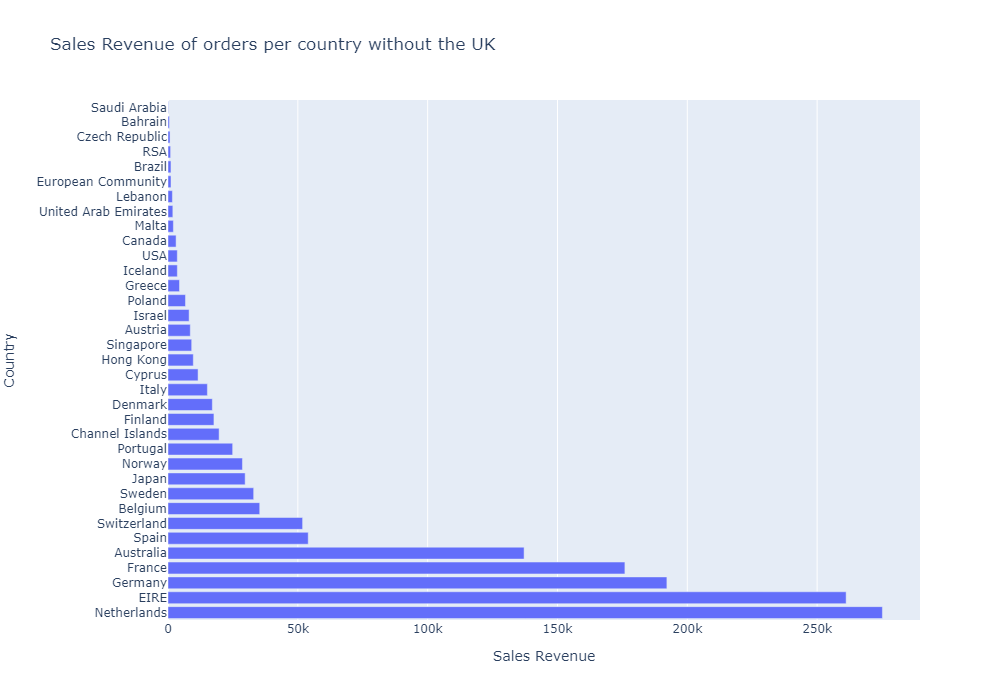

In [20]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country without the UK")
fig.show(renderer='png', height=700, width=1000)

In [24]:
def wordcloud_of_Description(df, title):
    """
    This fuction creates a word cloud
    inputs a data frame converts it to tuples and uses the input 'title' as the title of the word cloud
    """
    plt.rcParams["figure.figsize"] = (20,20)
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()


In [22]:
def display_side_by_side(dfs:list, captions:list):
   
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

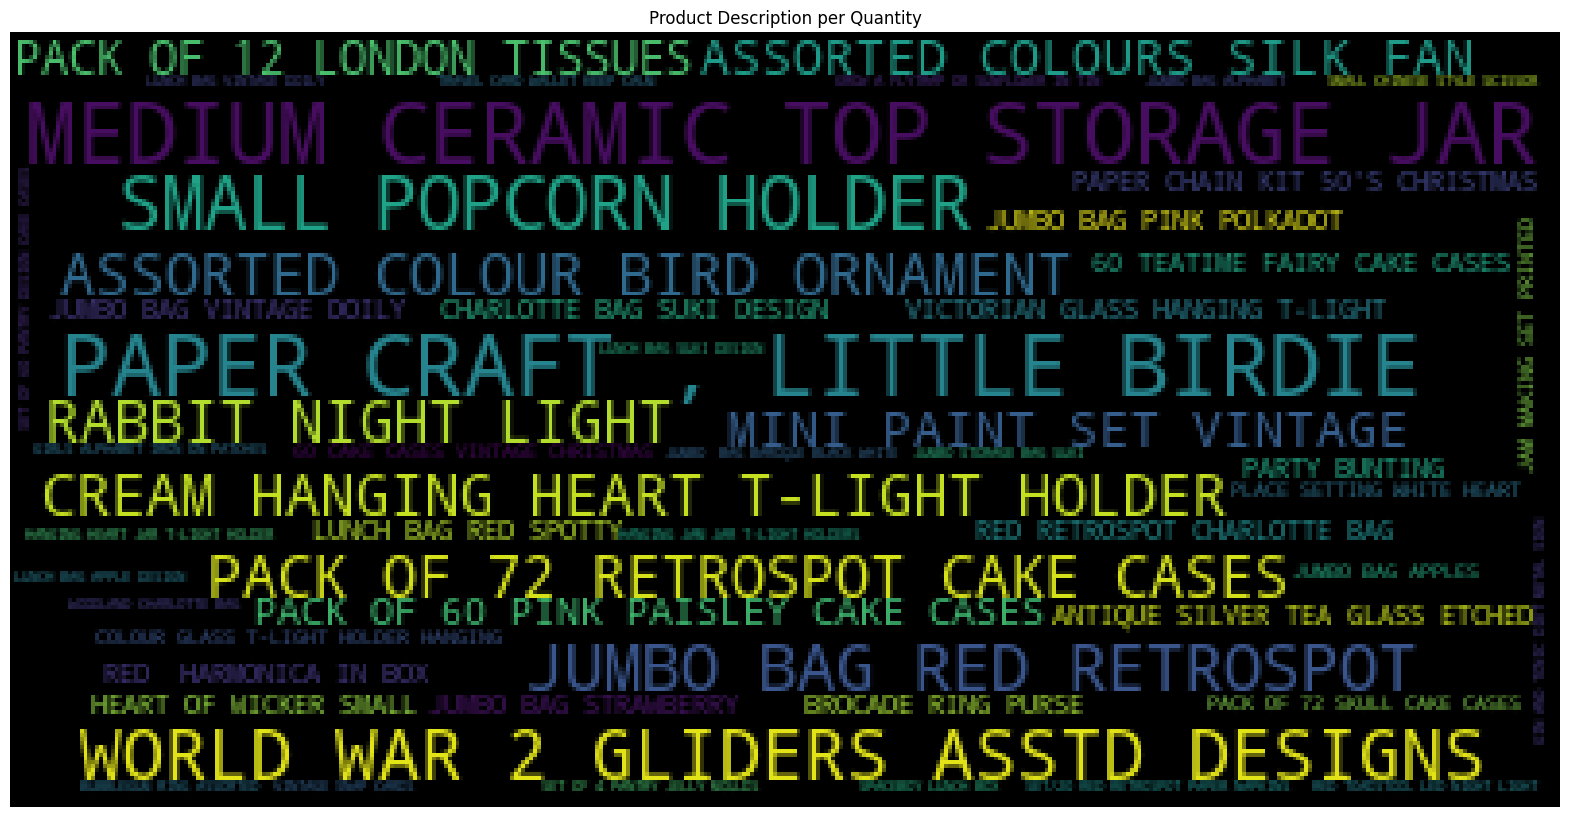

In [26]:
from wordcloud import WordCloud
temp_df = pd.DataFrame(df.groupby('Description')['Quantity'].sum()).reset_index()
title = "Product Description per Quantity"
wordcloud_of_Description(temp_df, title)

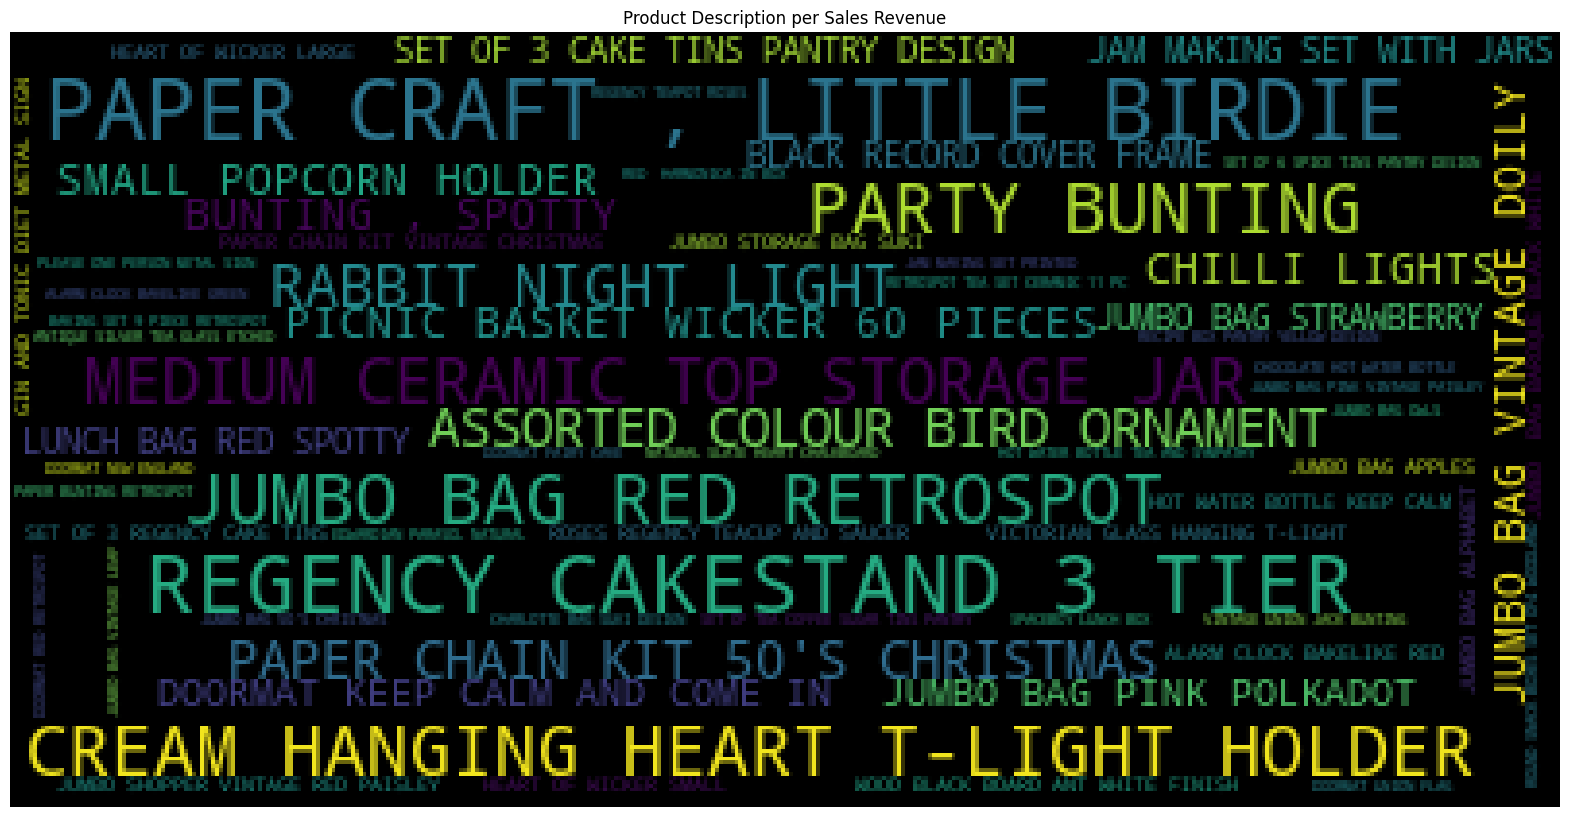

In [27]:
temp_df = pd.DataFrame(df.groupby('Description')['Sales Revenue'].sum()).reset_index()
title = "Product Description per Sales Revenue"
wordcloud_of_Description(temp_df, title)

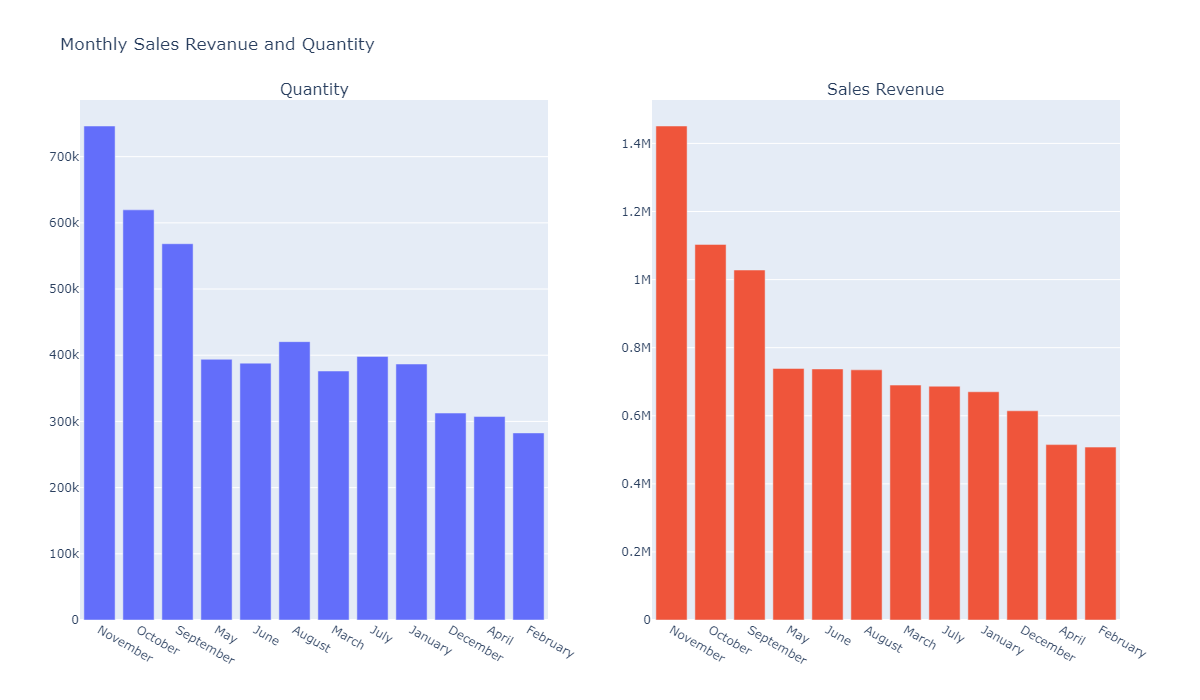

In [28]:
# monthly analysis of the Sales and the Quantity of iterms sold

temp_df = group_Quantity_and_SalesRevenue(df,'Month')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                  )

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Monthly Sales Revanue and Quantity")
fig.show(renderer='png', height=700, width=1200)


# The above graphs show the monthly trend of Quantity of products ordered(left) and Sales Revenue(right).
# Both the measures were the highest in Novemeber folllowed by October and Septemeber.

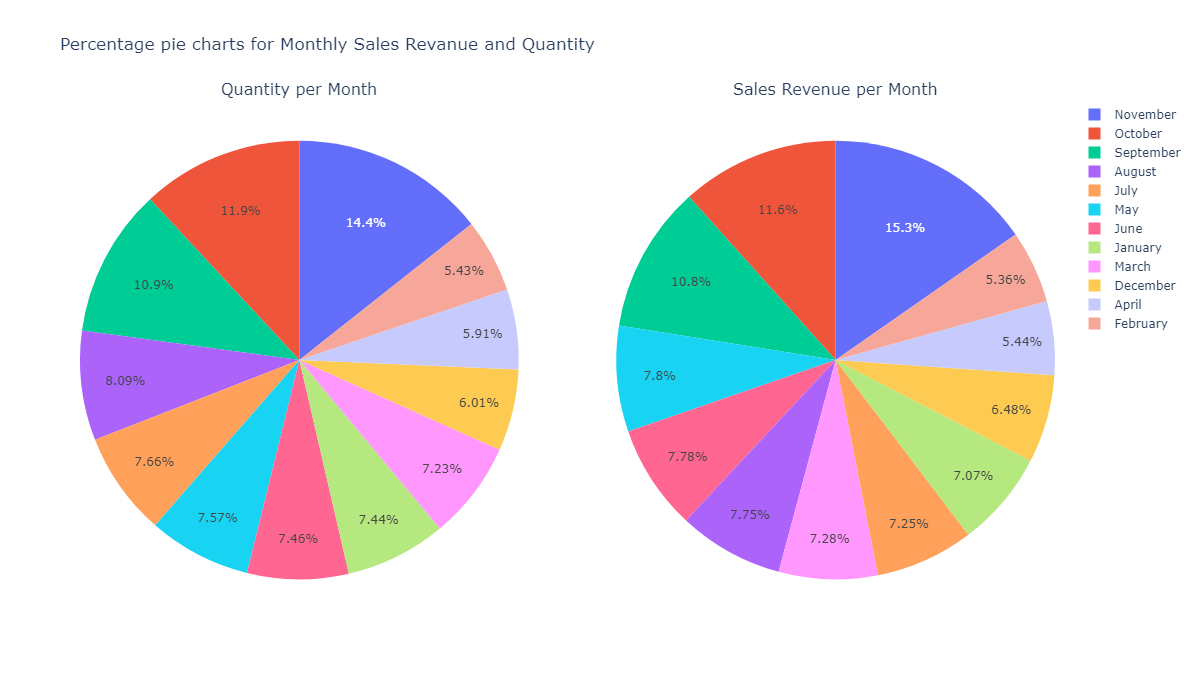

In [29]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity per Month", "Sales Revenue per Month")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Month'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Month'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Monthly Sales Revanue and Quantity")

fig.show(renderer='png', height=700, width=1200)


# The above pie charts depicts the quantity of products ordered and sales revenue per month
# with highest in the month of November with 14.4% and lowest in the month of february with 5.43%.

# Weekly Stats
The below are the weekly analysis of the Sales and the Quantity of iterms sold

In [ ]:
temp_df = group_Quantity_and_SalesRevenue(df,'Week of the Year')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Weekly Sales Revanue and Quantity")
fig.show(renderer='png', height=700, width=1200)


# The above graphs shows the weekly trend of sales revenue and the quantity of products ordered. 
# The highest peak was on the 49th week in the month of November.
# As it's a holiday season, there was a high demand for the decoration items.
# As the quantity increases sales revenue too increases.

# Daily Stats
The below are the daily analysis of the Sales and the Quantity of iterms sold 

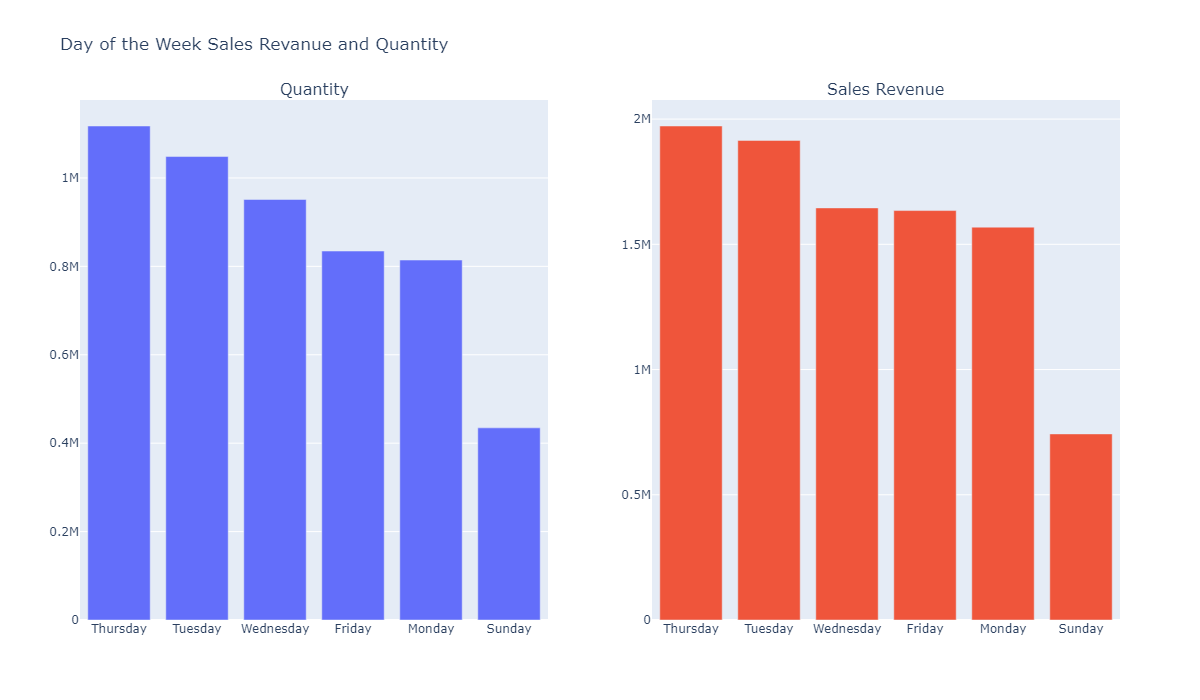

In [30]:
temp_df = group_Quantity_and_SalesRevenue(df,'Day of Week')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="Day of the Week Sales Revanue and Quantity")
fig.show(renderer='png', height=700, width=1200)

# The above graphs depict the daily trend of Sales revenue and quantity.
# Thursday was observed to generate the highest quantity of products and Sales Revenue.

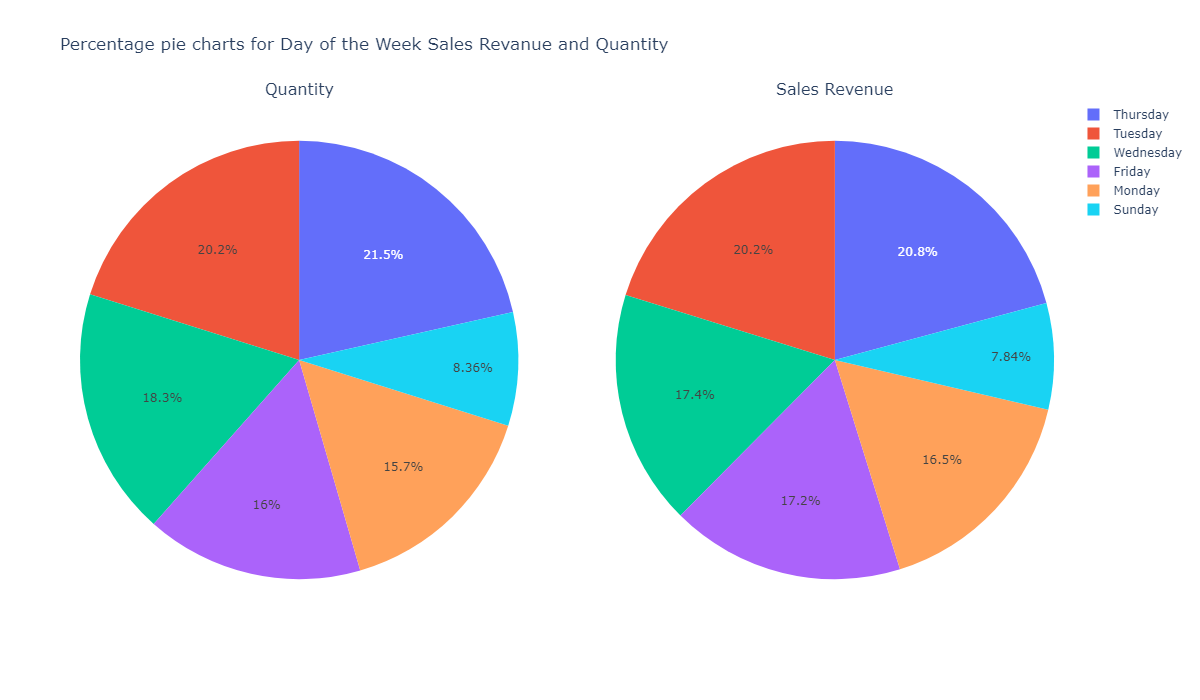

In [32]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Day of Week'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Day of Week'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Day of the Week Sales Revanue and Quantity")

fig.show(renderer='png', height=700, width=1200)


# The above pie charts shows the daily trend of sales revenue and quantity of products ordered.

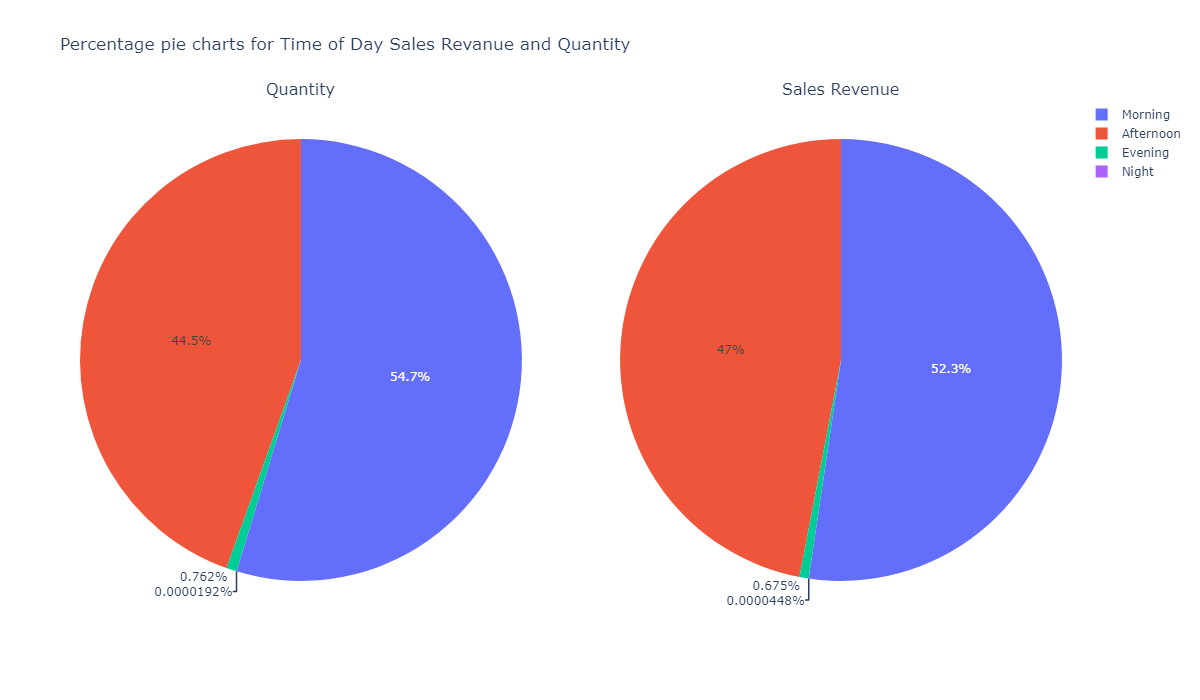

In [33]:
temp_df = group_Quantity_and_SalesRevenue(df,'Time of Day')
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Time of Day'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Time of Day'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Time of Day Sales Revanue and Quantity")


fig.show(renderer='png', height=700, width=1200)

# The above piecharts shows the breakdown of Quantity of orders(left) and Sales revenue(right) by time of the day.
# More than 99% of the orders were placed during mornings and afternoon.

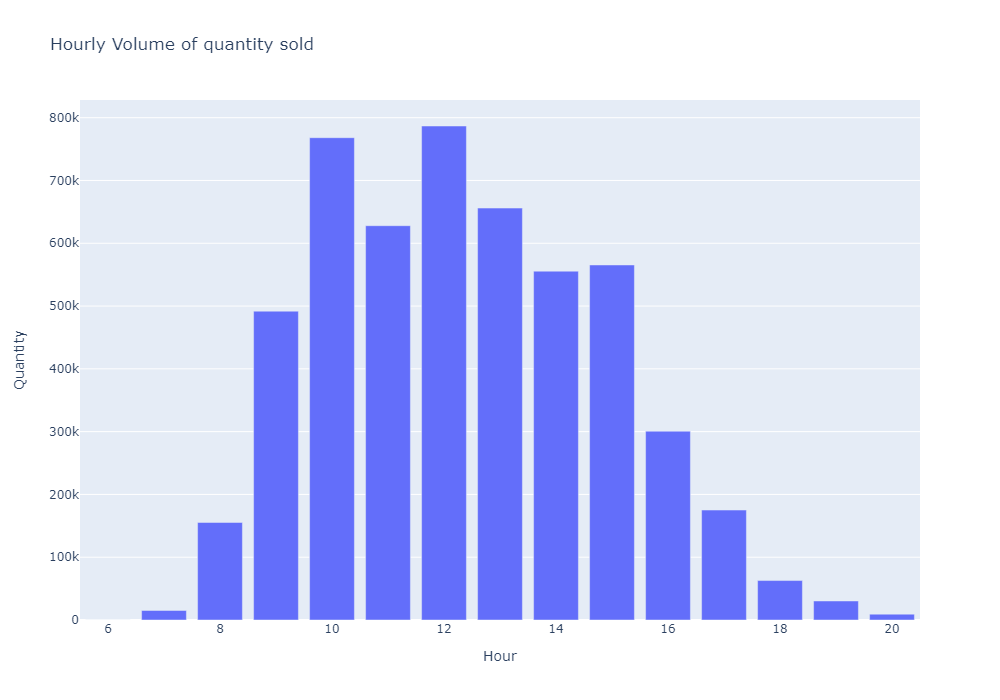

In [34]:
Hourly_Sales = (df.groupby('Hour').sum()["Quantity"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='Quantity', title='Hourly Volume of quantity sold')
fig.show(renderer='png', height=700, width=1000)

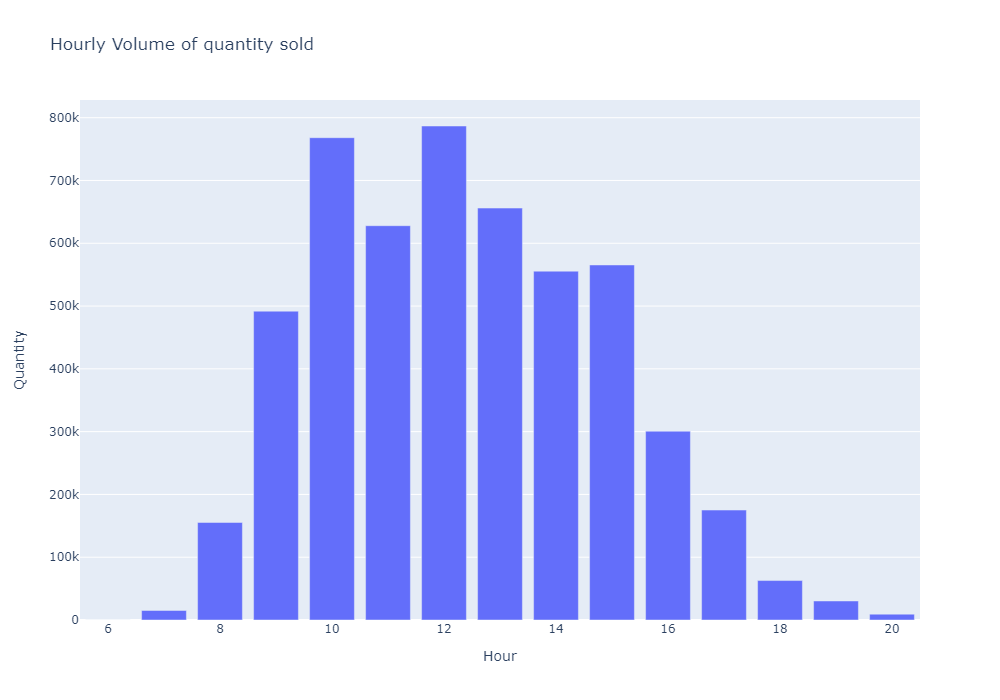

In [35]:
Hourly_Sales = (df.groupby('Hour').sum()["Quantity"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='Quantity', title='Hourly Volume of quantity sold')
fig.show(renderer='png', height=700, width=1000)

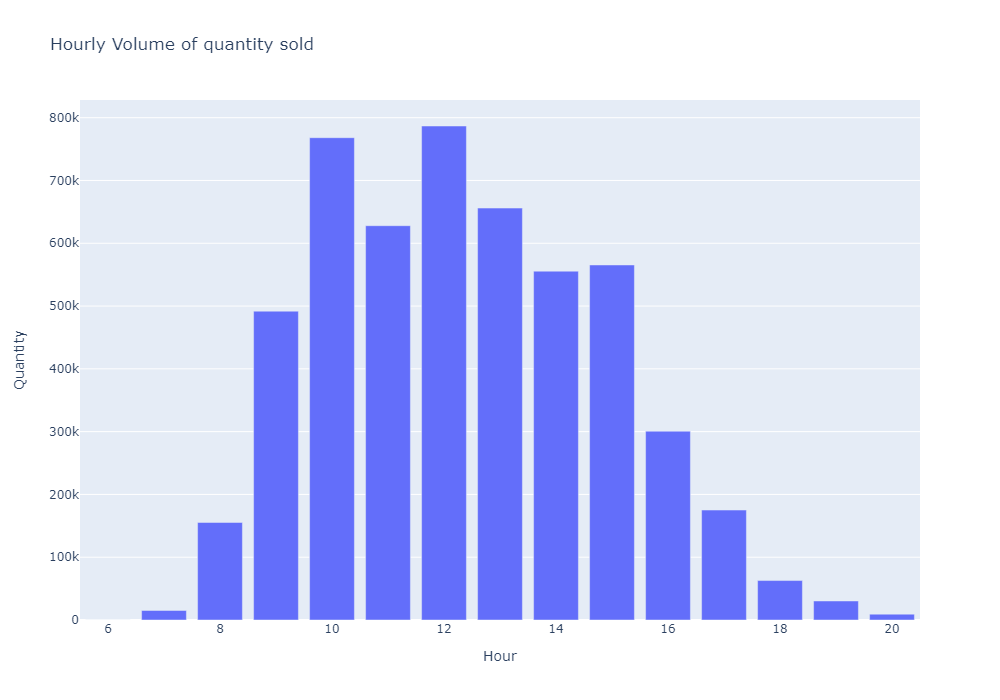

In [36]:
Hourly_Sales = (df.groupby('Hour').sum()["Quantity"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='Quantity', title='Hourly Volume of quantity sold')
fig.show(renderer='png', height=700, width=1000)

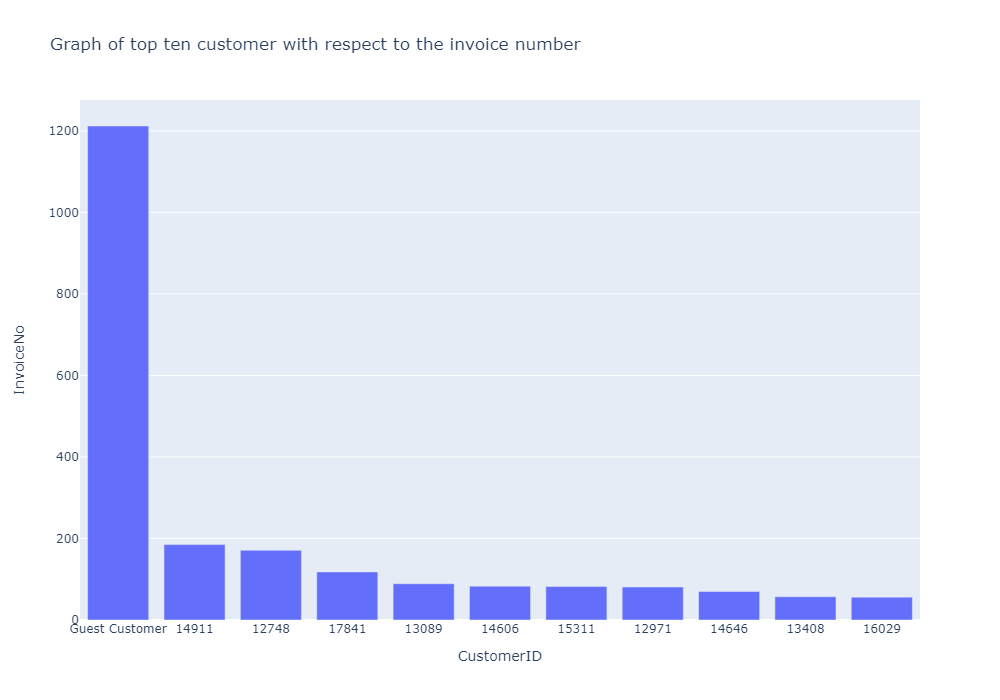

In [37]:
data = df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number')
fig.show(renderer='png', height=700, width=1000)

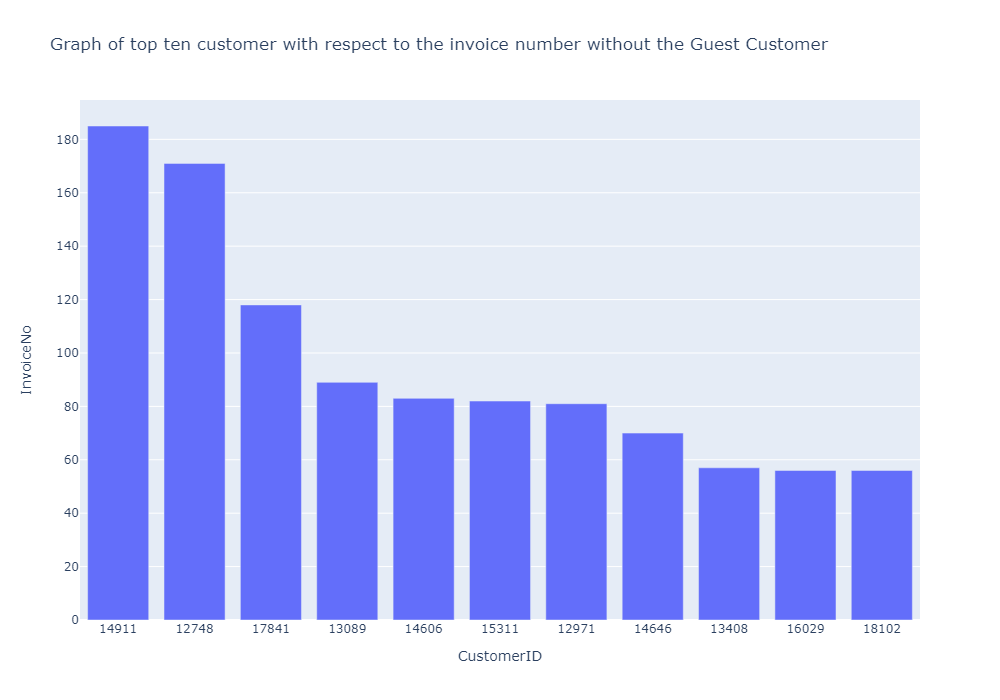

In [38]:
temp_df = df[df["CustomerID"] != "Guest Customer"]
data = temp_df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number without the Guest Customer')
fig.show(renderer='png', height=700, width=1000)

In [39]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Description')
Quantity_tempA = temp_df.sort_values(ascending=False, by = "Quantity").head(10).reset_index(drop=True)
Quantity_tempB = temp_df.sort_values(ascending=False, by = "Quantity").tail(10).reset_index(drop=True)

Quantity_tempA.drop('Sales Revenue', axis=1, inplace=True)
Quantity_tempB.drop('Sales Revenue', axis=1, inplace=True)
display_side_by_side([Quantity_tempA, Quantity_tempB], ['Top 10 Description by Quantity\n', 'Bottom 10 Description by Quantity\n'])

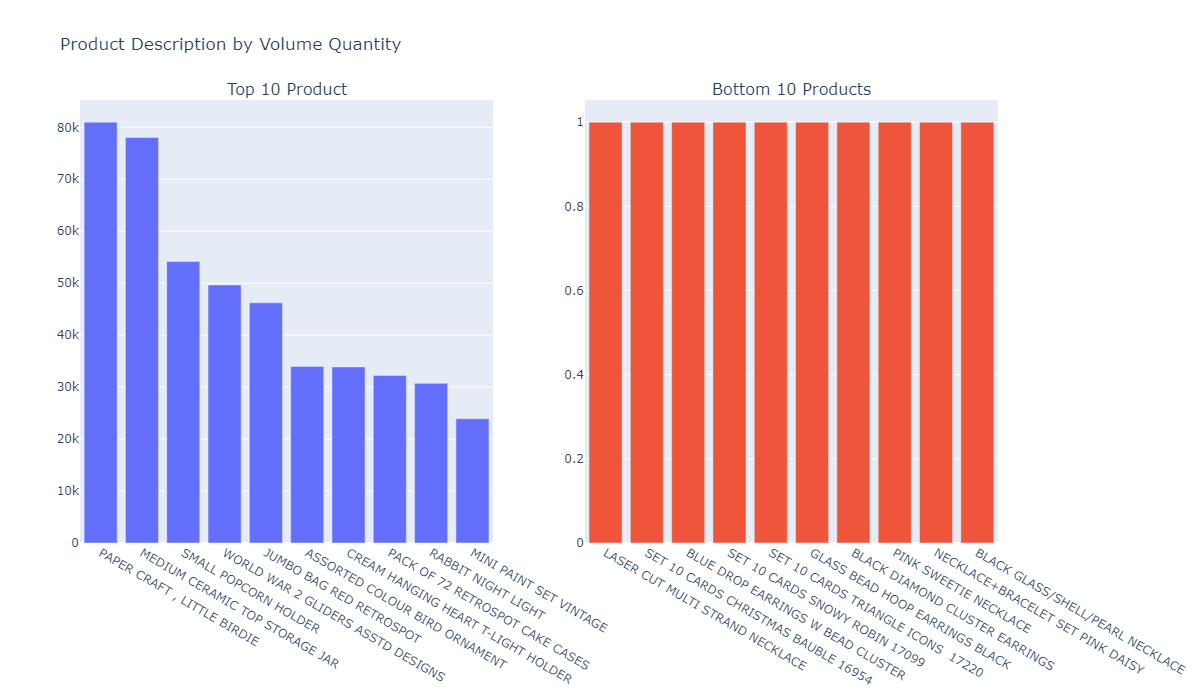

In [40]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Quantity_tempA['Description'], y=Quantity_tempA['Quantity'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Quantity_tempB['Description'], y=Quantity_tempB['Quantity'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Volume Quantity")
fig.show(renderer='png', height=700, width=1200)

# The above graphs depict the top 10 and bottom 10 products by volume quantity. 
# The product paper craft, little birdie was the most popular item whereas orange/
# fuschia stones necklace was the least popular item.

In [41]:
Sales_Revenue_tempA = temp_df.sort_values(ascending=False, by = "Sales Revenue").head(10).reset_index(drop=True)
Sales_Revenue_tempB = temp_df.sort_values(ascending=False, by = "Sales Revenue").tail(10).reset_index(drop=True)

Sales_Revenue_tempA.drop('Quantity', axis=1, inplace=True)
Sales_Revenue_tempB.drop('Quantity', axis=1, inplace=True)
display_side_by_side([Sales_Revenue_tempA, Sales_Revenue_tempB], ['Top 10 Description by Sales Revenue\n', 'Bottom 10 Description by Sales Revenue\n'])

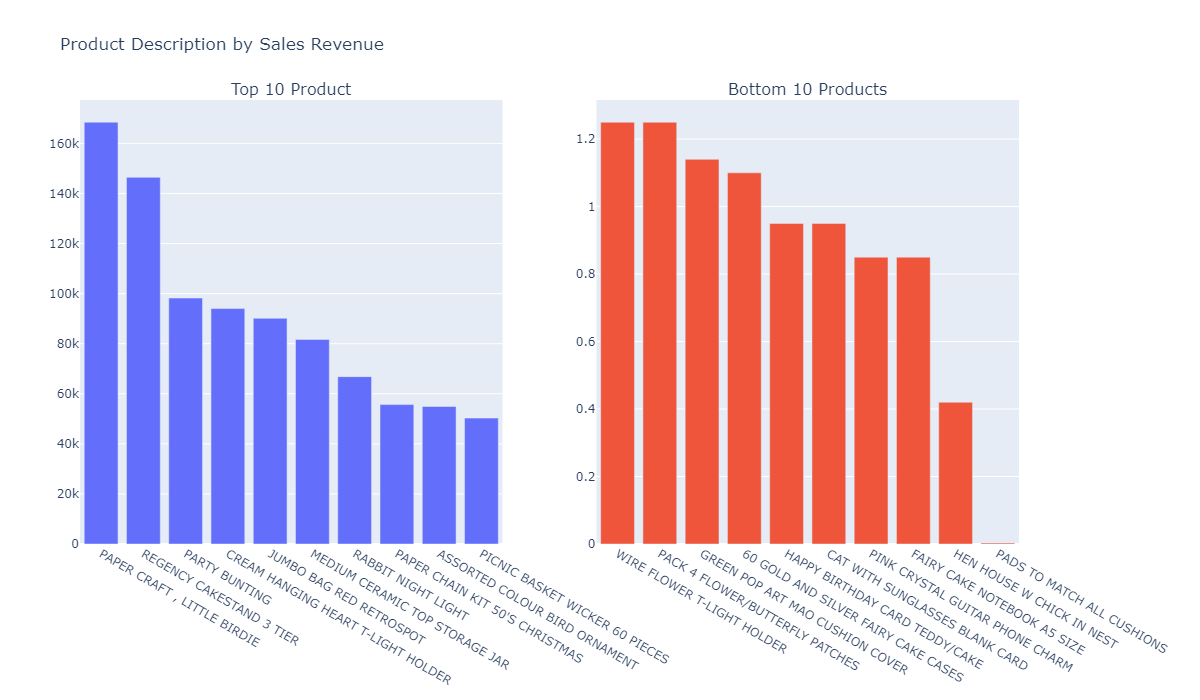

In [42]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Sales_Revenue_tempA['Description'], y=Sales_Revenue_tempA['Sales Revenue'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Sales_Revenue_tempB['Description'], y=Sales_Revenue_tempB['Sales Revenue'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Sales Revenue")
fig.show(renderer='png', height=700, width=1200)

# The above graphs depict the top 10 and bottom 10 products by sales revenue.
# The product paper craft, little birdie was found to be generating the highest sales and pads had the lowest sales.

In [43]:
country_list = list(dict(df['Country'].value_counts()).keys())
def choose_country(country = "all", data = df):
  """
  This fuction takes in a country name and filters the data frame for just country
  if the there is no country inputed the fuction return the un filtered dataframe
  """
  if country == "all":
    return data
  else:
    temp_df = data[data["Country"] == country]
    temp_df.reset_index(drop= True, inplace= True)

    return temp_df


In [46]:
MBA_df = choose_country(country="United Kingdom")
MBA_df.head()

# We are going to use the Apriori Algorithm for the association rule mining/analysis.
# Apriori is an algorithm for frequent item set mining and association rule learning over relational dataset. 

InvoiceNo StockCode                Description  Quantity  \
0    539993     22386    JUMBO BAG PINK POLKADOT        10   
1    539993     21499         BLUE POLKADOT WRAP        25   
2    539993     21498         RED RETROSPOT WRAP        25   
3    539993     22379    RECYCLING BAG RETROSPOT         5   
4    539993     20718  RED RETROSPOT SHOPPER BAG        10   

          InvoiceDate  UnitPrice CustomerID         Country        Date  \
0 2011-01-04 10:00:00       1.95      13313  United Kingdom  2011-01-04   
1 2011-01-04 10:00:00       0.42      13313  United Kingdom  2011-01-04   
2 2011-01-04 10:00:00       0.42      13313  United Kingdom  2011-01-04   
3 2011-01-04 10:00:00       2.10      13313  United Kingdom  2011-01-04   
4 2011-01-04 10:00:00       1.25      13313  United Kingdom  2011-01-04   

     Month  Week of the Year Day of Week      Time  Hour Time of Day  \
0  January                 1     Tuesday  10:00:00    10     Morning   
1  January                 1     Tuesday  10:00:00    10     Morning   
2  January                 1     Tuesday  10:00:00    10     Morning   
3  January                 1     Tuesday  10:00:00    10     Morning   
4  January                 1     Tuesday  10:00:00    10     Morning   

   Sales Revenue  
0           19.5  
1           10.5  
2           10.5  
3           10.5  
4           12.5

In [47]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [48]:
#we are going to rearrage the dataframe having the 'InvoiceNo' column the index, so that each row contains all the items purchased under the same invoice
basket = (MBA_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

In [49]:
basket.head()

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                          0.0                         0.0   
540001                          0.0                         0.0   
540002                          0.0                         0.0   
540003                          0.0                         0.0   
540004                          0.0                         0.0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                             0.0                        0.0   
540001                             0.0                        0.0   
540002                             0.0                        0.0   
540003                             0.0                        0.0   
540004                             0.0                        0.0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
539993                                0.0                               0.0   
540001                                0.0                               0.0   
540002                                0.0                               0.0   
540003                                0.0                               0.0   
540004                                0.0                               0.0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
539993                                   0.0                            0.0   
540001                                   0.0                            0.0   
540002                                   0.0                            0.0   
540003                                   0.0                            0.0   
540004                                   0.0                            0.0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
539993                                       0.0                          0.0   
540001                                       0.0                          0.0   
540002                                       0.0                          0.0   
540003                                       0.0                          0.0   
540004                                       0.0                          0.0   

Description  ...  ZINC METAL HEART DECORATION  ZINC STAR T-LIGHT HOLDER  \
InvoiceNo    ...                                                          
539993       ...                          0.0                       0.0   
540001       ...                          0.0                       0.0   
540002       ...                          0.0                       0.0   
540003       ...                          0.0                       0.0   
540004       ...                          0.0                       0.0   

Description  ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
InvoiceNo                                                                  
539993                             0.0                               0.0   
540001                             0.0                               0.0   
540002                             0.0                               0.0   
540003                             0.0                               0.0   
540004                             0.0                               0.0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
539993                                   0.0                              0.0   
540001                                   0.0                        

In [50]:
def encoder(x):
  if(x <= 0):
    return 0
  if(x >= 1):
    return 1

#now we encode
basket = basket.applymap(encoder)
basket.head()

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                            0                           0   
540001                            0                           0   
540002                            0                           0   
540003                            0                           0   
540004                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                               0                          0   
540001                               0                          0   
540002                               0                          0   
540003                               0                          0   
540004                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
539993                                  0                                 0   
540001                                  0                                 0   
540002                                  0                                 0   
540003                                  0                                 0   
540004                                  0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
539993                                     0                              0   
540001                                     0                              0   
540002                                     0                              0   
540003                                     0                              0   
540004                                     0                              0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
539993                                         0                            0   
540001                                         0                            0   
540002                                         0                            0   
540003                                         0                            0   
540004                                         0                            0   

Description  ...  ZINC METAL HEART DECORATION  ZINC STAR T-LIGHT HOLDER  \
InvoiceNo    ...                                                          
539993       ...                            0                         0   
540001       ...                            0                         0   
540002       ...                            0                         0   
540003       ...                            0                         0   
540004       ...                            0                         0   

Description  ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
InvoiceNo                                                                  
539993                               0                                 0   
540001                               0                                 0   
540002                               0                                 0   
540003                               0                                 0   
540004                               0                                 0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
539993                                     0                                0   
540001                                     0                        

In [51]:
basket = basket[ (basket > 0).sum(axis=1) >= 2]
basket.head()

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
InvoiceNo                                                         
539993                            0                           0   
540001                            0                           0   
540002                            0                           0   
540003                            0                           0   
540005                            0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
InvoiceNo                                                           
539993                               0                          0   
540001                               0                          0   
540002                               0                          0   
540003                               0                          0   
540005                               0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
InvoiceNo                                                                     
539993                                  0                                 0   
540001                                  0                                 0   
540002                                  0                                 0   
540003                                  0                                 0   
540005                                  0                                 0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
InvoiceNo                                                                     
539993                                     0                              0   
540001                                     0                              0   
540002                                     0                              0   
540003                                     0                              0   
540005                                     0                              0   

Description  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
InvoiceNo                                                                       
539993                                         0                            0   
540001                                         0                            0   
540002                                         0                            0   
540003                                         0                            0   
540005                                         0                            0   

Description  ...  ZINC METAL HEART DECORATION  ZINC STAR T-LIGHT HOLDER  \
InvoiceNo    ...                                                          
539993       ...                            0                         0   
540001       ...                            0                         0   
540002       ...                            0                         0   
540003       ...                            0                         0   
540005       ...                            0                         0   

Description  ZINC SWEETHEART SOAP DISH  ZINC SWEETHEART WIRE LETTER RACK  \
InvoiceNo                                                                  
539993                               0                                 0   
540001                               0                                 0   
540002                               0                                 0   
540003                               0                                 0   
540005                               0                                 0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
539993                                     0                                0   
540001                                     0                        

In [54]:
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
frequent_itemsets.head()

C:\Users\91700\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



support                               itemsets
0  0.034107  (3 DRAWER ANTIQUE WHITE WOOD CABINET)
1  0.022015     (3 HOOK PHOTO SHELF ANTIQUE WHITE)
2  0.025892             (3 STRIPEY MICE FELTCRAFT)
3  0.023132          (4 TRADITIONAL SPINNING TOPS)
4  0.051718               (6 RIBBONS RUSTIC CHARM)

In [56]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules = rules.sort_values("lift",ascending=False).reset_index(drop= True)
rules.head()

antecedents  \
0  (WOODEN HEART CHRISTMAS SCANDINAVIAN)   
1   (WOODEN STAR CHRISTMAS SCANDINAVIAN)   
2         (SMALL MARSHMALLOWS PINK BOWL)   
3   (SMALL DOLLY MIX DESIGN ORANGE BOWL)   
4       (PINK REGENCY TEACUP AND SAUCER)   

                                         consequents  antecedent support  \
0               (WOODEN STAR CHRISTMAS SCANDINAVIAN)            0.031609   
1              (WOODEN HEART CHRISTMAS SCANDINAVIAN)            0.029506   
2               (SMALL DOLLY MIX DESIGN ORANGE BOWL)            0.027666   
3                     (SMALL MARSHMALLOWS PINK BOWL)            0.032529   
4  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...            0.045673   

   consequent support   support  confidence       lift  leverage  conviction  
0            0.029506  0.023198    0.733888  24.872093  0.022265    3.646933  
1            0.031609  0.023198    0.786192  24.872093  0.022265    4.529244  
2            0.032529  0.021621    0.781473  24.023575  0.020721    4.427230  
3            0.027666  0.021621    0.664646  24.023575  0.020721    2.899428  
4            0.042913  0.032201    0.705036  16.429605  0.030241    3.244760

In [57]:
rules.describe()

antecedent support  consequent support     support  confidence  \
count          334.000000          334.000000  334.000000  334.000000   
mean             0.065237            0.065237    0.025887    0.440207   
std              0.023680            0.023680    0.005263    0.149768   
min              0.025235            0.025235    0.020043    0.169154   
25%              0.048630            0.048630    0.022097    0.327508   
50%              0.063317            0.063317    0.024118    0.425694   
75%              0.074390            0.074390    0.028570    0.534396   
max              0.122889            0.122889    0.049090    0.902394   

             lift    leverage  conviction  
count  334.000000  334.000000  334.000000  
mean     7.434008    0.021688    1.859595  
std      3.500720    0.004969    0.842402  
min      1.583403    0.008523    1.085437  
25%      5.455632    0.018583    1.412745  
50%      6.566377    0.020721    1.627491  
75%      8.117633    0.023813    2.012612  
max     24.872093    0.040465    9.658857

In [58]:
temp_df = rules.head(50).copy()
temp_df.head()

antecedents  \
0  (WOODEN HEART CHRISTMAS SCANDINAVIAN)   
1   (WOODEN STAR CHRISTMAS SCANDINAVIAN)   
2         (SMALL MARSHMALLOWS PINK BOWL)   
3   (SMALL DOLLY MIX DESIGN ORANGE BOWL)   
4       (PINK REGENCY TEACUP AND SAUCER)   

                                         consequents  antecedent support  \
0               (WOODEN STAR CHRISTMAS SCANDINAVIAN)            0.031609   
1              (WOODEN HEART CHRISTMAS SCANDINAVIAN)            0.029506   
2               (SMALL DOLLY MIX DESIGN ORANGE BOWL)            0.027666   
3                     (SMALL MARSHMALLOWS PINK BOWL)            0.032529   
4  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...            0.045673   

   consequent support   support  confidence       lift  leverage  conviction  
0            0.029506  0.023198    0.733888  24.872093  0.022265    3.646933  
1            0.031609  0.023198    0.786192  24.872093  0.022265    4.529244  
2            0.032529  0.021621    0.781473  24.023575  0.020721    4.427230  
3            0.027666  0.021621    0.664646  24.023575  0.020721    2.899428  
4            0.042913  0.032201    0.705036  16.429605  0.030241    3.244760

In [59]:
RFM_df = choose_country(country="United Kingdom")

In [60]:
#the first thing that we are going to need is the reference date 
#in this case the day after the last recorded date in the dataset plus a day
ref_date = RFM_df['InvoiceDate'].max() + dt.timedelta(days=1)
ref_date 

Timestamp('2011-12-10 12:49:00')

In [61]:
#for RFM we are going to remove the 'Guest Customer' the customers without Customer ID
df_temp = RFM_df[RFM_df['CustomerID'] != "Guest Customer"]

In [63]:
RFM_df = df_temp.groupby('CustomerID').agg({'InvoiceDate': lambda x: (ref_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'Sales Revenue': lambda x: x.sum()})

RFM_df.columns = ['Recency', 'Frequency', 'Monetary']
RFM_df["R"] = pd.qcut(RFM_df['Recency'].rank(method="first"), 4, labels=[4, 3, 2, 1])
RFM_df["F"] = pd.qcut(RFM_df['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df["M"] = pd.qcut(RFM_df['Monetary'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df['RFM_Score'] = (RFM_df['R'].astype(int)+RFM_df['F'].astype(int)+RFM_df['M'].astype(int))

RFM_df.reset_index(inplace=True)

RFM_df.head()

CustomerID  Recency  Frequency  Monetary  R  F  M  RFM_Score
0      12346      326          1  77183.60  1  1  4          6
1      12747        2          9   3489.74  4  4  4         12
2      12748        1        171  27508.01  4  4  4         12
3      12749        4          5   4040.88  4  4  4         12
4      12820        3          4    942.34  4  3  3         10

In [64]:
RFM_df[["RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("RFM_Score").agg(["mean", "count"])

Recency        Frequency           Monetary      
                 mean count       mean count         mean count
RFM_Score                                                      
3          239.799228   259   1.000000   259   156.555946   259
4          189.821670   443   1.076749   443   245.367878   443
5          121.619910   442   1.280543   442   343.939844   442
6           83.008969   446   1.553812   446   633.752982   446
7           74.256614   378   2.113757   378   647.212968   378
8           57.058496   359   2.740947   359  1097.447994   359
9           39.449086   383   3.425587   383  1194.476661   383
10          34.008824   340   5.023529   340  2317.973000   340
11          20.232143   336   7.282738   336  3037.044613   336
12           6.848341   422  14.353081   422  7720.947156   422

In [65]:
#now we will use the standard scalr function from SKlean preprocessing and scale transform fit the data (without the Customer Id column)
scaler = StandardScaler()
RFM_df_log = RFM_df[['Recency','Frequency','Monetary','RFM_Score']]
RFM_df_scaled = scaler.fit_transform(RFM_df_log)
RFM_df_scaled = pd.DataFrame(RFM_df_scaled)
RFM_df_scaled.columns = ['Recency','Frequency','Monetary','RFM_Score']

RFM_df_scaled.head()

Recency  Frequency   Monetary  RFM_Score
0  2.694897  -0.461169  10.651878  -0.532027
1 -0.921065   0.761126   0.242665   1.596080
2 -0.932226  25.512592   3.635231   1.596080
3 -0.898745   0.149978   0.320513   1.596080
4 -0.909905  -0.002809  -0.117154   0.886711

In [66]:
the_scores = []
for i in range(2,11): #we will explore from 2 to 10 clusters
  kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10,max_iter=50,verbose=0)
  kmeans.fit(RFM_df_scaled)
  the_scores.append(kmeans.inertia_)

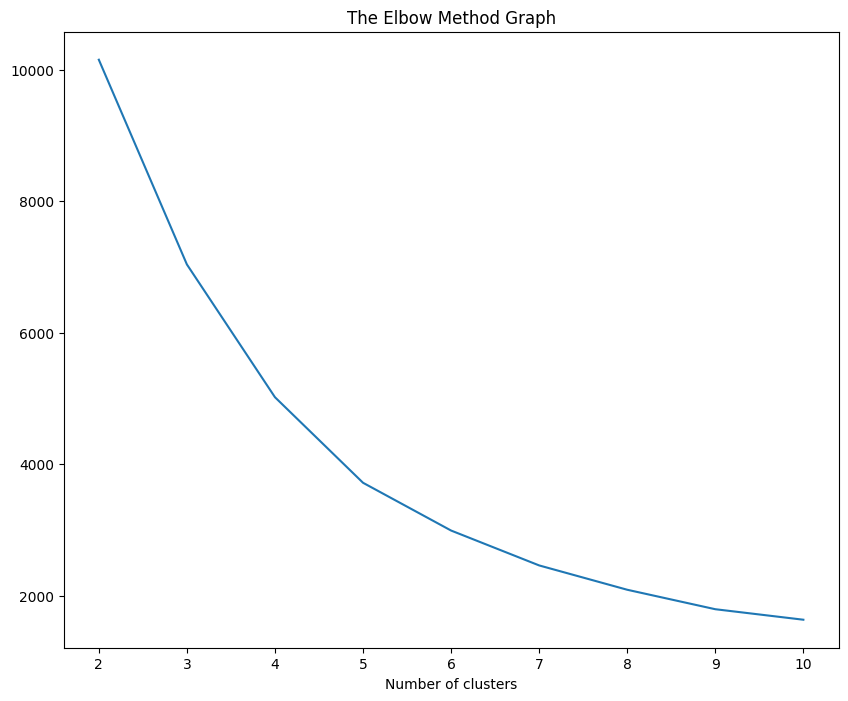

In [67]:
#lets plot the Elbow
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(range(2,11,1),the_scores)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.xticks(ticks=range(2,11))
plt.show()

In [68]:
#calculating the silhouette_score from the sklearn metrics module function silhouette_score
for i in range(2,11): 
  kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10,max_iter=50,verbose=0)
  kmeans.fit(RFM_df_scaled)
  silhouette = silhouette_score(RFM_df_scaled,kmeans.labels_)
  print("for {} clusters the silhouette_score is {}".format(i,silhouette))

for 2 clusters the silhouette_score is 0.4264491348194375
for 3 clusters the silhouette_score is 0.4462013193496353
for 4 clusters the silhouette_score is 0.4612315261572034
for 5 clusters the silhouette_score is 0.4641100519828001
for 6 clusters the silhouette_score is 0.4611889649590919
for 7 clusters the silhouette_score is 0.4639355987219177
for 8 clusters the silhouette_score is 0.4227710164578688
for 9 clusters the silhouette_score is 0.4037097642436135
for 10 clusters the silhouette_score is 0.39735165657654203


In [69]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=10,max_iter=50,verbose=0)
kmeans.fit(RFM_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [70]:
RFM_df['Clusters'] = kmeans.labels_

RFM_df.head()

CustomerID  Recency  Frequency  Monetary  R  F  M  RFM_Score  Clusters
0      12346      326          1  77183.60  1  1  4          6         2
1      12747        2          9   3489.74  4  4  4         12         3
2      12748        1        171  27508.01  4  4  4         12         2
3      12749        4          5   4040.88  4  4  4         12         3
4      12820        3          4    942.34  4  3  3         10         3

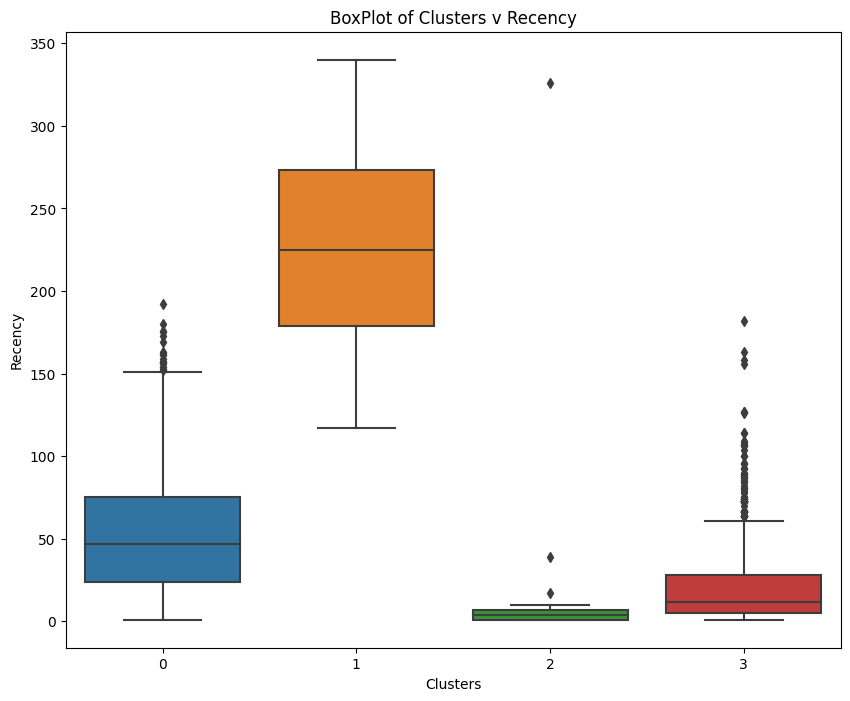

In [71]:
sns.boxplot( x= 'Clusters',y= 'Recency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Recency")
plt.show()

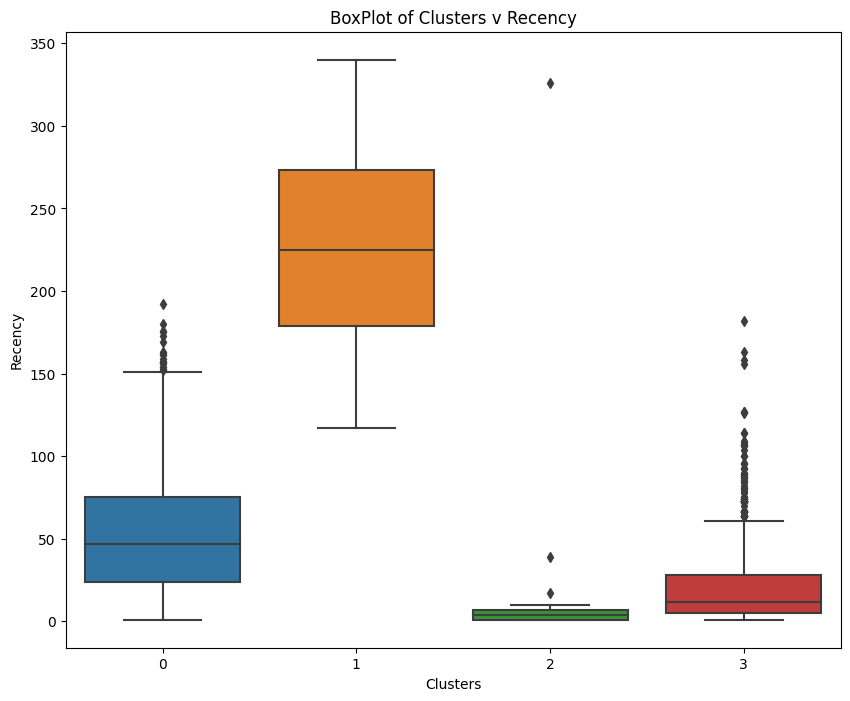

In [72]:
sns.boxplot( x= 'Clusters',y= 'Recency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Recency")
plt.show()

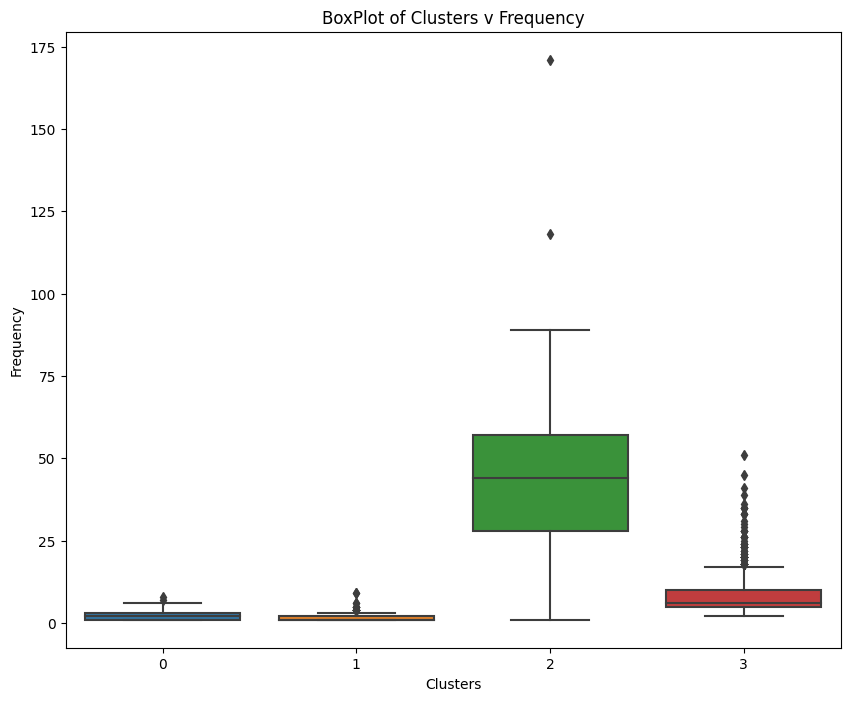

In [73]:
sns.boxplot( x= 'Clusters',y= 'Frequency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Frequency")
plt.show()

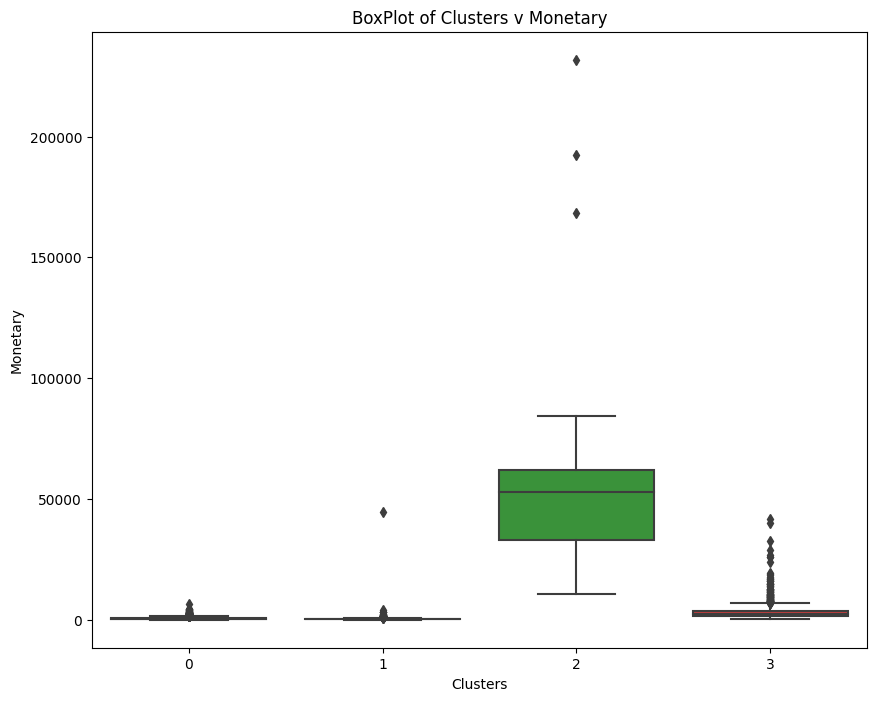

In [74]:
sns.boxplot( x= 'Clusters',y= 'Monetary' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Monetary")
plt.show()

In [75]:
temp_df = RFM_df[["Clusters","RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("Clusters").agg(["mean"])
temp_df.columns = ["RFM_Score mean", "Recency mean", "Frequency mean", "Monetary mean"]
temp_df

RFM_Score mean  Recency mean  Frequency mean  Monetary mean
Clusters                                                             
0               6.910100     53.083241        2.074917     642.791284
1               4.279642    227.687919        1.404922     430.260930
2              11.640000     18.280000       51.680000   63680.692000
3              11.031279     20.445262        8.293468    3322.771978

In [76]:
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("RFM_Score", "Recency", "Frequency","Monetary"),
                    specs=specs
                    )

fig.add_trace(
    go.Pie(values = temp_df['RFM_Score mean'], labels = temp_df.index,
    name = 'RFM_Score'),
    1, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Recency mean'], labels = temp_df.index,
    name = 'Recency'),
    1, 2
)
fig.add_trace(
    go.Pie(values = temp_df['Frequency mean'], labels = temp_df.index,
    name = 'Frequency'),
    2, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Monetary mean'], labels = temp_df.index,
    name = 'Monetary'),
    2, 2
)
fig.update_layout(height=800, width=1200, title_text=" ")
fig.show()

C:\Users\91700\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\91700\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [78]:
# The product recommendation part of this project is going to make use of the 
# Association Rules that where uncovered in the MBA section.
from numpy.lib.arraysetops import unique

product_catalog = list(unique(MBA_df['Description']))

##### we have 3823 products in our catalog.
Now we are going to create a fuction that inputs an item or itemset would be the antecede the fuction goes through the rules and output a consequent that has the highest lift as the recommended product or set of products.
So, we will be doing People who bought this product or products also bought this or this set of products.

In [79]:
def remove_from_list(y, item_to_search):
  newlist = list()
  for i in y:
    if i not in item_to_search:
      newlist.append(i)
  return newlist

In [80]:
def search_list(item_to_search, list_to_search = rules['antecedents']):
  print(item_to_search)
  max_lift = 0
  item_to_recommend = ''
  for i, item in enumerate(list_to_search):
    if set(list(item_to_search)).issubset(set(list(item))):
      if rules['lift'][i] > max_lift:
        max_lift = rules['lift'][i]
        y = list(rules['antecedents'][i])
        x = remove_from_list(y, item_to_search)
        item_to_recommend = list(rules['consequents'][i]) + x
  if item_to_recommend == '':
    print("There are no Product recommendations")
  else:
    return print(f"People who bought this also bought: {item_to_recommend}")


In [81]:
for i in range(len(product_catalog)):
  search_list([product_catalog[i]])

['10 COLOUR SPACEBOY PEN']
There are no Product recommendations
['12 COLOURED PARTY BALLOONS']
There are no Product recommendations
['12 DAISY PEGS IN WOOD BOX']
There are no Product recommendations
['12 EGG HOUSE PAINTED WOOD']
There are no Product recommendations
['12 HANGING EGGS HAND PAINTED']
There are no Product recommendations
['12 IVORY ROSE PEG PLACE SETTINGS']
There are no Product recommendations
['12 MESSAGE CARDS WITH ENVELOPES']
There are no Product recommendations
['12 PENCIL SMALL TUBE WOODLAND']
There are no Product recommendations
['12 PENCILS SMALL TUBE RED RETROSPOT']
There are no Product recommendations
['12 PENCILS SMALL TUBE SKULL']
There are no Product recommendations
['12 PENCILS TALL TUBE POSY']
There are no Product recommendations
['12 PENCILS TALL TUBE RED RETROSPOT']
There are no Product recommendations
['12 PENCILS TALL TUBE SKULLS']
There are no Product recommendations
['12 PENCILS TALL TUBE WOODLAND']
There are no Product recommendations
['12 PINK HEN+CHI

There are no Product recommendations
['BLUE BUNNY EASTER EGG BASKET']
There are no Product recommendations
['BLUE CALCULATOR RULER']
There are no Product recommendations
['BLUE CAT BISCUIT BARREL PINK HEART']
There are no Product recommendations
['BLUE CHARLIE+LOLA PERSONAL DOORSIGN']
There are no Product recommendations
['BLUE CHECK BAG W HANDLE 34X20CM']
There are no Product recommendations
['BLUE CHENILLE SHAGGY CUSHION COVER']
There are no Product recommendations
['BLUE CIRCLES DESIGN MONKEY DOLL']
There are no Product recommendations
['BLUE CIRCLES DESIGN TEDDY']
There are no Product recommendations
['BLUE CLIMBING HYDRANGA ART FLOWER']
There are no Product recommendations
['BLUE COAT RACK PARIS FASHION']
There are no Product recommendations
['BLUE CRUSOE CHECK LAMPSHADE']
There are no Product recommendations
['BLUE CRYSTAL BOOT PHONE CHARM']
There are no Product recommendations
['BLUE CUSHION COVER WITH FLOWER']
There are no Product recommendations
['BLUE DAISY MOBILE']
There are

There are no Product recommendations
['DANISH ROSE ROUND SEWING BOX']
There are no Product recommendations
['DANISH ROSE TRINKET TRAYS']
There are no Product recommendations
['DANISH ROSE UMBRELLA STAND']
There are no Product recommendations
['DARK BIRD HOUSE TREE DECORATION']
There are no Product recommendations
['DECORATION  BUTTERFLY  MAGIC GARDEN']
There are no Product recommendations
['DECORATION  PINK CHICK MAGIC GARDEN']
There are no Product recommendations
['DECORATION , WOBBLY CHICKEN, METAL']
There are no Product recommendations
['DECORATION , WOBBLY RABBIT , METAL']
There are no Product recommendations
['DECORATION WHITE CHICK MAGIC GARDEN']
There are no Product recommendations
['DECORATIVE CATS BATHROOM BOTTLE']
There are no Product recommendations
['DECORATIVE FLORE BATHROOM BOTTLE']
There are no Product recommendations
['DECORATIVE HANGING SHELVING UNIT']
There are no Product recommendations
['DECORATIVE PLANT POT WITH FRIEZE']
There are no Product recommendations
['DECOR

There are no Product recommendations
['GREETING CARD, STICKY GORDON']
There are no Product recommendations
['GREETING CARD, TWO SISTERS.']
There are no Product recommendations
['GREETING CARD,SQUARE, DOUGHNUTS']
There are no Product recommendations
['GREY ACRYLIC FACETED BANGLE']
There are no Product recommendations
['GREY FLORAL FELTCRAFT SHOULDER BAG']
There are no Product recommendations
['GREY HEART HOT WATER BOTTLE']
There are no Product recommendations
['GROOVY CACTUS INFLATABLE']
There are no Product recommendations
['GROW A FLYTRAP OR SUNFLOWER IN TIN']
There are no Product recommendations
['GROW YOUR OWN BASIL IN ENAMEL MUG']
There are no Product recommendations
['GROW YOUR OWN FLOWERS SET OF 3']
There are no Product recommendations
['GROW YOUR OWN HERBS SET OF 3']
There are no Product recommendations
['GROW YOUR OWN PLANT IN A CAN']
There are no Product recommendations
['GUMBALL COAT RACK']
There are no Product recommendations
['GUMBALL MAGAZINE RACK']
There are no Product re

There are no Product recommendations
['MODERN VINTAGE COTTON SHOPPING BAG']
There are no Product recommendations
['MONEY BOX BISCUITS DESIGN']
There are no Product recommendations
['MONEY BOX CONFECTIONERY DESIGN']
There are no Product recommendations
['MONEY BOX FIRST AID DESIGN']
There are no Product recommendations
['MONEY BOX HOUSEKEEPING DESIGN']
There are no Product recommendations
['MONEY BOX KINGS CHOICE DESIGN']
There are no Product recommendations
['MONEY BOX POCKET MONEY DESIGN']
There are no Product recommendations
['MONSTERS STENCIL CRAFT']
There are no Product recommendations
['MONTANA DIAMOND CLUSTER EARRINGS']
There are no Product recommendations
['MONTANA DIAMOND CLUSTER NECKLACE']
There are no Product recommendations
['MOODY BOY  DOOR HANGER']
There are no Product recommendations
['MOODY GIRL DOOR HANGER']
There are no Product recommendations
['MOP PENDANT SHELL NECKLACE']
There are no Product recommendations
['MORE BUTTER METAL SIGN']
There are no Product recommendat

There are no Product recommendations
['REGENCY CAKESTAND 3 TIER']
People who bought this also bought: ['GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER']
['REGENCY MILK JUG PINK']
There are no Product recommendations
['REGENCY MIRROR WITH SHUTTERS']
There are no Product recommendations
['REGENCY SUGAR BOWL GREEN']
There are no Product recommendations
['REGENCY SUGAR TONGS']
There are no Product recommendations
['REGENCY TEA PLATE GREEN']
There are no Product recommendations
['REGENCY TEA PLATE PINK']
There are no Product recommendations
['REGENCY TEA PLATE ROSES']
There are no Product recommendations
['REGENCY TEA SPOON']
There are no Product recommendations
['REGENCY TEA STRAINER']
There are no Product recommendations
['REGENCY TEAPOT ROSES']
There are no Product recommendations
['REINDEER HEART DECORATION GOLD']
There are no Product recommendations
['REINDEER HEART DECORATION SILVER']
There are no Product recommendations
['RELAX LARGE WOOD LETTERS']
There are no Pr

There are no Product recommendations
['STANDING FAIRY POLE SUPPORT']
There are no Product recommendations
['STAR  T-LIGHT HOLDER']
There are no Product recommendations
['STAR DECORATION PAINTED ZINC']
There are no Product recommendations
['STAR DECORATION RUSTIC']
There are no Product recommendations
['STAR PORTABLE TABLE LIGHT']
There are no Product recommendations
['STAR T-LIGHT HOLDER WILLIE WINKIE']
There are no Product recommendations
['STAR WOODEN CHRISTMAS DECORATION']
There are no Product recommendations
['STAR WREATH DECORATION WITH BELL']
There are no Product recommendations
['STARFISH SOAP DISH']
There are no Product recommendations
['STARS GIFT TAPE']
There are no Product recommendations
['STEEL SWEETHEART ROUND TABLE CREAM']
There are no Product recommendations
['STOOL HOME SWEET HOME']
There are no Product recommendations
['STORAGE TIN HOME SWEET HOME']
There are no Product recommendations
['STORAGE TIN VINTAGE DOILY']
There are no Product recommendations
['STRAWBERRIES  